In [ ]:
#import relavant libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import KFold
from tqdm import tqdm

In [ ]:
#fetch data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

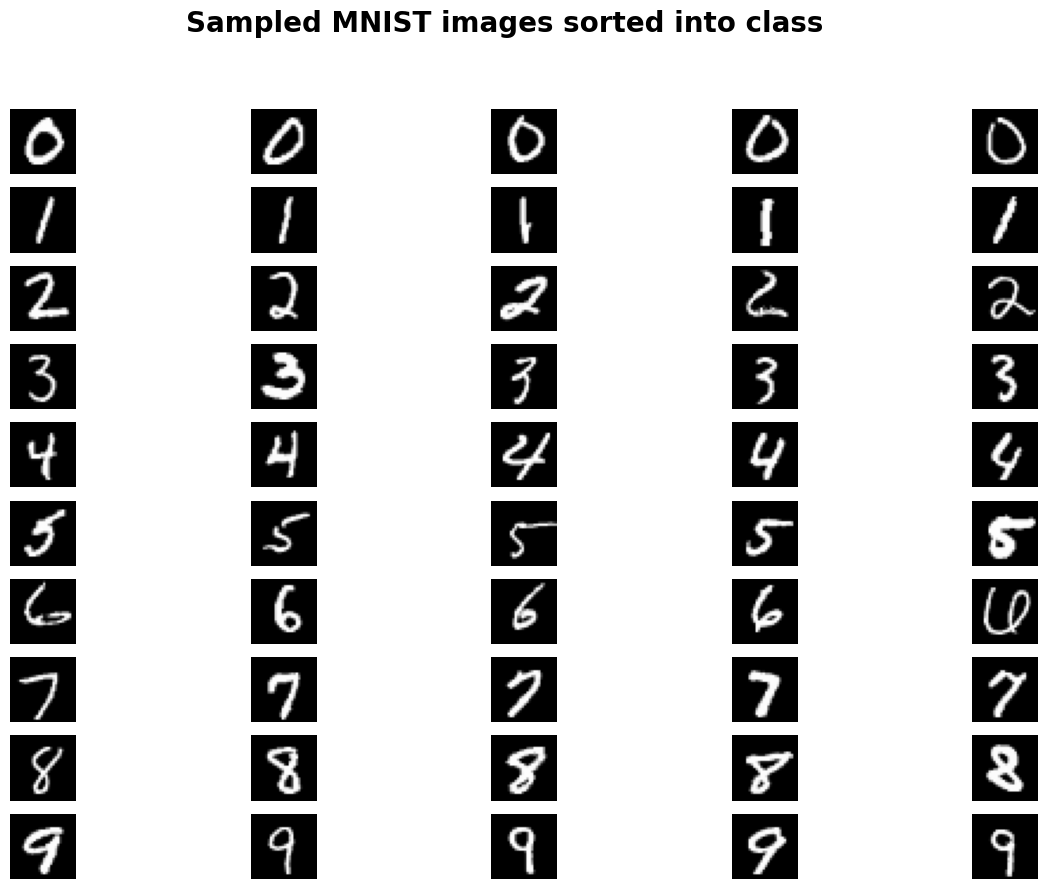

In [ ]:
#plot 5 images per MNIST cluster
f=(15,10)
classes = 10
imgs_per_class = 5
fig, axes = plt.subplots(classes, imgs_per_class, figsize=f)
for mnist_dig in range(classes):
    indexes = np.where(y==mnist_dig)[0]
    chosen = np.random.choice(indexes, imgs_per_class, replace=False)
    for i, idx in enumerate(chosen):
        ax = axes[mnist_dig, i]
        ax.imshow(X[idx].reshape(28, 28), cmap="gray")
        ax.axis("off")
        # Label the first column of each row
        if i == 0:
            ax.set_ylabel(f"{mnist_dig}", fontsize=14, rotation=0, labelpad=40, va='center')
            
fig.suptitle("Sampled MNIST images sorted into class", fontsize=20, fontweight="bold")
fig.savefig("mnist_samples.png", dpi=300)
plt.show()

In [ ]:
#Use PCA to reduce data to 80 features
n = 80
scaler = StandardScaler(with_std=False)
X_centred = scaler.fit_transform(X)
pca = PCA(n_components=n)
X_PCA = pca.fit_transform(X_centred)

PCA completed, reduced to 80 features.



In [ ]:
#define the hyperparameters to explore
hyperparams_gmm = {
    "n_components": [10],
    "covariance_type": ["full", "diag", "tied"],
    "n_init": [5, 10, 20]
}

#split the data for cross validations
cvfunc = KFold(n_splits=3, shuffle=True, random_state=42)
#set up progress bar
total_g_runs = (
    len(hyperparams_gmm["n_components"]) *
    len(hyperparams_gmm["covariance_type"]) *
    len(hyperparams_gmm["n_init"])
)
pbar = tqdm(total=total_g_runs, desc="GMM K-Fold CV")
best_score_g = -1
best_params_g = None

#iterate through every combination of hyperparameters
for n_comp in hyperparams_gmm["n_components"]:
    for cov in hyperparams_gmm["covariance_type"]:
        for n_init in hyperparams_gmm["n_init"]:
            fold_scores = []
            #cv split
            splitdata = cvfunc.split(X_PCA)
            for t, v in splitdata:
                X_train, X_val = X_PCA[t], X_PCA[v]
                #input the current combo into GMM and fit, find silhouette score
                gmm = GaussianMixture(
                    n_components=n_comp,
                    covariance_type=cov,
                    n_init=n_init,
                    random_state=42
                )
                gmm.fit(X_train)
                labels_val = gmm.predict(X_val)
                sil = silhouette_score(X_val, labels_val)
                fold_scores.append(sil)

            #we find which combination has the best silhouette mean
            sil_mean = np.mean(fold_scores)
            if sil_mean > best_score_g:
                best_score_g = sil_mean
                best_params_g = {"n_components": n_comp,"covariance_type": cov,"n_init": n_init}
            pbar.update(1)
pbar.close()
print("Best GMM params:", best_params_g)

#create optimum GMM and assign the labels
gmm = GaussianMixture(
    n_components=best_params_g["n_components"],
    covariance_type=best_params_g["covariance_type"],
    n_init=best_params_g["n_init"],
    random_state=42
)
gmm.fit(X_PCA)
labels_g = gmm.predict(X_PCA)

GMM K-Fold CV:   0%|                                                                             | 0/6 [00:00<?, ?it/s]

In [ ]:
#define hyperparameter ranges for Kmeans
hyperparams_k = {
    "n_clusters": [10],
    "max_iter": [100, 300],
    "n_init": [5, 10, 15, 20]
}

#cross validation
cvfunc = KFold(n_splits=3, shuffle=True, random_state=42)
total_k_runs = (
    len(hyperparams_k["n_clusters"]) *
    len(hyperparams_k["max_iter"]) *
    len(hyperparams_k["n_init"])
)
pbar = tqdm(total=total_k_runs, desc="KMeans K-Fold CV")
best_score_k = -1
best_params_k = None

#iterate through all combinations of hyperparams
for n_clusters in hyperparams_k["n_clusters"]:
    for max_iter in hyperparams_k["max_iter"]:
        for n_init in hyperparams_k["n_init"]:
            fold_scores = []
            ##cross validation
            splitdata = cvfunc.split(X_PCA)
            for t, v in splitdata:
                X_train, X_val = X_PCA[t], X_PCA[v]
                #evaluate model on current set
                model = KMeans(
                    n_clusters=n_clusters,
                    max_iter=max_iter,
                    n_init=n_init,
                    random_state=42
                )
                model.fit(X_train)
                labels_val = model.predict(X_val)
                sil = silhouette_score(X_val, labels_val)
                fold_scores.append(sil)

            #choose best silhouette mean returning combo fo [params]
            sil_mean = np.mean(fold_scores)
            if sil_mean > best_score_k:
                best_score_k = sil_mean
                best_params_k = {"n_clusters": n_clusters, "max_iter": max_iter, "n_init": n_init}
            pbar.update(1)
pbar.close()
print("Best KMeans params:", best_params_k)

#create Kmeans model with optimum params and assign labels
kmeans = KMeans(
    n_clusters=best_params_k["n_clusters"],
    max_iter=best_params_k["max_iter"],
    n_init=best_params_k["n_init"],
    random_state=42
)
kmeans.fit(X_PCA)
labels_k = kmeans.labels_

In [ ]:
##print out relevant measurement metrics for both clustering methods
print("\nKMEANS METRICS")
print("Adjusted Rand Index KMeans:", adjusted_rand_score(y, labels_k))
print("Adjusted Mutual Info KMeans:", adjusted_mutual_info_score(y, labels_k))
print("Silhouette KMeans:", silhouette_score(X_PCA, labels_k))

print("\nGMM METRICS")
print("Adjusted Rand Index GMM:", adjusted_rand_score(y, labels_g))
print("Adjusted Mutual Info GMM:", adjusted_mutual_info_score(y, labels_g))
print("Silhouette GMM:", silhouette_score(X_PCA, labels_g))


In [ ]:
#reduce the 80 feature datas to two components with highest covariance 
scaler = StandardScaler(with_std=False)
X_centred_2 = scaler.fit_transform(X_PCA)
pca = PCA(n_components=2)
X_PCA_2D = pca.fit_transform(X_centred_2)
print("Reduced to 2 features for graphing.\n")

In [ ]:
#plot visualisation of how they clusters two most important features
K_k = best_params_k["n_clusters"]
K_g = best_params_g["n_components"]

fig, ax = plt.subplots(figsize=(8,6))
for cluster in range(K_k):
    i = np.where(labels_k == cluster)[0]
    comps = X_PCA_2D[i]
    ax.scatter(comps[:,0], comps[:,1])

#add cluster centres overlaid
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           s=30, c='black', marker='X')

ax.set_title("2D K-Means clustering", fontweight="bold")
fig.tight_layout()
fig.savefig("2d_Kmeans.png", dpi=300)
plt.show()

NameError: name 'best_params_k' is not defined

In [ ]:
#plot for GMM 2D clustering
fig, ax = plt.subplots(figsize=(8,6))
for cluster in range(K_g):
    i = np.where(labels_g == cluster)[0]
    comps = X_PCA_2D[i]
    ax.scatter(comps[:,0], comps[:,1])

ax.set_title("2D GMM clustering", fontweight="bold")
fig.tight_layout()
fig.savefig("2D_GMM.png", dpi=300)
plt.show()


In [ ]:
#evaluate the best model based on the bestscore calculated
if best_score_k > best_score_g:
    print("K MEANS")
    labels = labels_k
    K = K_k
    model = "K-Means"
else:
    print("GMM")
    labels = labels_g
    K = K_g
    model = "GMM"
print(f"{model} is the best performing model\n")


#visualise images clusters created by said model
fig, axes = plt.subplots(K, 5, figsize=(15, K*1.5))
for cluster in range(K):
    indices = np.where(labels == cluster)[0]
    num_images = min(5, len(indices))
    chosen_images = np.random.choice(indices, num_images, replace=False)
    for n, index in enumerate(chosen_images):
        ax = axes[cluster, n]
        ax.imshow(X[index].reshape(28, 28), cmap="gray")  # axes-level
        ax.axis("off")                                     # axes-level

fig.suptitle(f"Best clustering visualization – {model}", fontweight="bold")  # figure-level
fig.tight_layout(rect=[0, 0, 1, 0.95])  # figure-level: leave space for suptitle
fig.savefig("Clusted_MNIST.png", dpi=300)
plt.show()